In [2]:
# Import libraries

import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras import layers
import time
import pathlib

Using TensorFlow backend.


In [0]:
output_dir = '/content/output'

In [0]:
# Load colored images 
colored_images = np.load('colored_images.npy')

In [0]:
# Load gray images 
gray_images = np.load('gray_images.npy')

In [0]:
# Function to load images from image path
def load_image(image_path, gray=False):
    img = image.load_img(image_path, target_size=(256, 256))
    if gray:
        img = image.load_img(image_path, target_size=(256, 256), color_mode='grayscale')
    else:
        img = image.load_img(image_path, target_size=(256, 256))
    img = image.img_to_array(img)
    return img

In [0]:
# Function to plot images
def plot(arr):

    fig = plt.figure(figsize=(4,4))
    for i in range(0, 16):
        plt.subplot(4, 4, 1 + i, xticks=[], yticks=[])
        plt.imshow(arr[i])

    plt.tight_layout()
    
    return plt

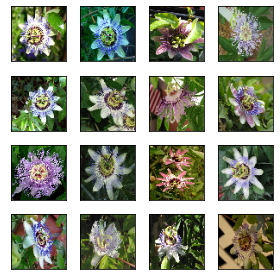

In [11]:
# Plot colored images 
plt = plot(colored_images)

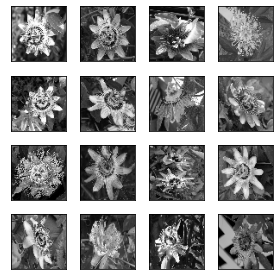

In [12]:
# Plot gray images
plt = plot(gray_images)

In [0]:
BUFFER_SIZE = colored_images.shape[0]
BATCH_SIZE = 128

In [0]:
# Downsampling layer

def downsample(filters, size, batchnorm=True):

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(filters, size, strides=2, use_bias=False, padding='same'))
  
  if batchnorm:
    model.add(layers.BatchNormalization())

  model.add(layers.LeakyReLU())

  return model

In [0]:
# Upsampling layer
def upsample(filters, size, dropout=False):

  model = tf.keras.Sequential()
  model.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))

  model.add(layers.BatchNormalization())

  if dropout:
      model.add(layers.Dropout(0.5))

  model.add(layers.LeakyReLU())

  return model

In [0]:
# Generator based on Tensorflow's Pix2Pix generator with minor modifications

def generator_model():
    
    inputs = tf.keras.layers.Input(shape=[64,64,3])

    down_stack = [
      downsample(32, 4, batchnorm=False), 
      downsample(64, 4), 
      downsample(128, 4), 
      downsample(256, 4), 
      downsample(512, 4), 
      downsample(1024, 4)
    ]

    up_stack = [
      upsample(1024, 4, dropout=True), 
      upsample(512, 4, dropout=True), 
      upsample(256, 4, dropout=True),
      upsample(128, 4), 
      upsample(64, 4),
    ]

    last_layer = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')
    x = inputs

    # Downsampling 
    skips = []
    for down in down_stack:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling 
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = layers.Concatenate()([x, skip])

    x = last_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


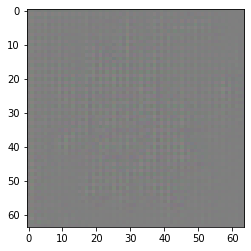

In [17]:
# Create generator model and test with a random sample noise 
generator = generator_model()

gray_test = []
gray_test.append(gray_images[0])
gray_test = np.array(gray_test)
gray_test.shape
generated_image = generator(gray_test, training=False)

plt.imshow(generated_image[0])

In [0]:
# Descriminator model PatchGAN
def discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 6]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    return model

In [0]:
discriminator = discriminator_model()

In [20]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 32)   1536        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 16, 16, 64)   33024       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 8, 8, 128)    131584      sequential_1[0][0]               
______________________________________________________________________________________________

In [21]:
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        6208      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)       

In [0]:
# Binary Crossentropy Loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss


In [0]:
lamda = 100

def generator_loss(color_images, generated_images, fake_output):
    
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(color_images - generated_images))
    total_gen_loss = gen_loss + (lamda * l1_loss)
    
    return total_gen_loss
    
    

In [0]:
# Optimizers 

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((colored_images, gray_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
EPOCHS = 100

In [0]:
# Train step function as defined in the tensorflow tutorial. 

@tf.function
def train_step(color_images, gray_images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(gray_images, training=True)

        real_input_pair = layers.concatenate([gray_images, color_images])
        real_output = discriminator(real_input_pair, training=True)
        fake_input_pair = layers.concatenate([gray_images, generated_images])
        fake_output = discriminator(fake_input_pair, training=True)

        gen_loss = generator_loss(color_images, generated_images, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #tf.print("Generator Loss: ", gen_loss, "Discriminator Loss: ", disc_loss)

In [0]:
# Define train functions as per Tensorflow tutorial 

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for color_image_batch, gray_image_batch in train_dataset:
            train_step(color_image_batch, gray_image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, gray_image_batch, color_image_batch)

        #if (epoch + 1) % 15 == 0:
        #    checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs,  gray_image_batch, color_image_batch)

In [0]:
def generate_and_save_images(model, epoch, test_input, label):

    predictions = model(test_input, training=False)

    plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(predictions[0])
    axarr[1].imshow(test_input[0])
    axarr[2].imshow(label[0])

    if epoch % 10 == 0:
      plt.savefig(output_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

<Figure size 432x288 with 0 Axes>

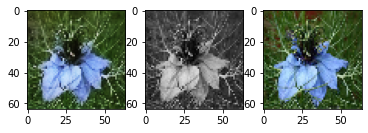

In [38]:
train(train_dataset, EPOCHS)

In [0]:
colored_images_test = np.load('colored_images_test.npy')
gray_images_test = np.load('gray_images_test.npy')
test_images = tf.data.Dataset.from_tensor_slices((colored_images_test, gray_images_test)).shuffle(1).batch(1)

<Figure size 432x288 with 0 Axes>

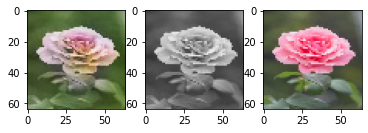

<Figure size 432x288 with 0 Axes>

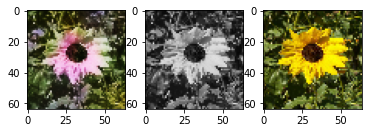

<Figure size 432x288 with 0 Axes>

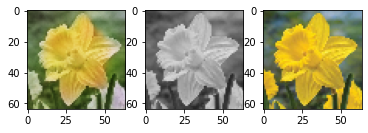

<Figure size 432x288 with 0 Axes>

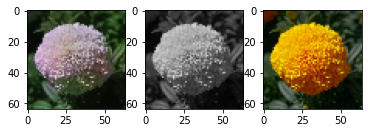

<Figure size 432x288 with 0 Axes>

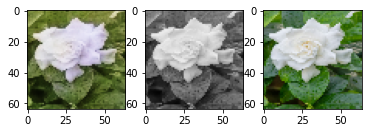

<Figure size 432x288 with 0 Axes>

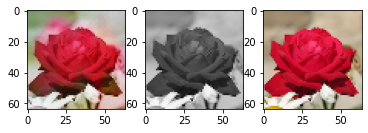

<Figure size 432x288 with 0 Axes>

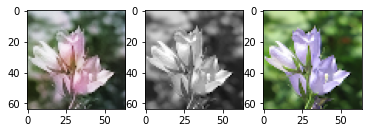

<Figure size 432x288 with 0 Axes>

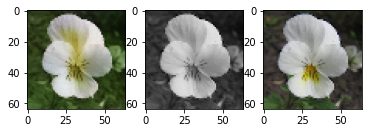

<Figure size 432x288 with 0 Axes>

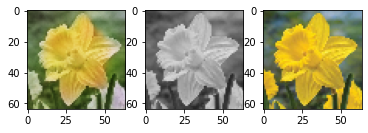

In [41]:
for color_image, gray_image in test_images:
  generate_and_save_images(generator, 1, gray_image, color_image)